<a href="https://colab.research.google.com/github/Adrianosh3/NeuronaleNetze/blob/main/NN_dc_tl_p_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.10.0+cu111  Device: cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


SETTINGS

In [4]:
NUM_CLASSES = 2

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
Number_Epochs = 5
BATCH_SIZE = 10

In [5]:
from torchvision.transforms.transforms import RandomHorizontalFlip
####Data augmentation
# Note transforms.ToTensor() scales input images
# to 0-1 range

## train transformations
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
                               ])

## valid transformations
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
                               ])

In [6]:
##########################
### Dog and Cat Dataset
##########################

training_dataset = datasets.ImageFolder('/content/drive/MyDrive/Hausarbeit/Data/min/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/Hausarbeit/Data/min/val', transform=transform)


#####################################################
### Data Loaders
#####################################################

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle=False)

In [7]:
# Checking the dataset
print(len(training_dataset))
print(len(validation_dataset))

502
200


In [8]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in validation_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([10, 3, 224, 224])
Image label dimensions: torch.Size([10])
Image batch dimensions: torch.Size([10, 3, 224, 224])
Image label dimensions: torch.Size([10])


Also: batsch size 10, 3 channels, Bilder 224x224

In [9]:
classes = ('cat', 'dog')

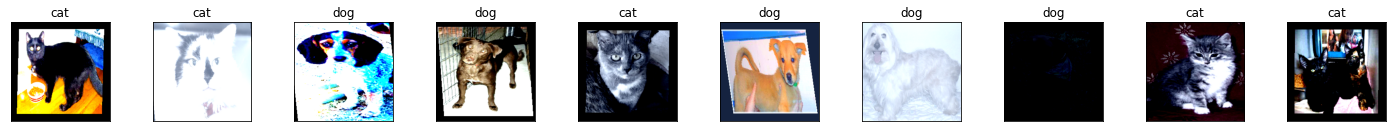

In [10]:
#### plot 20 training examples

##### convert Tensor to image
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

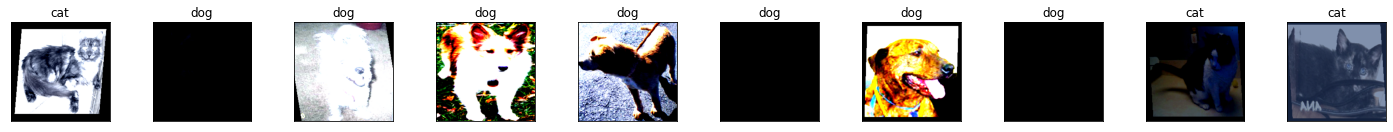

In [11]:
#### plot 20 validation examples
dataiter_val = iter(validation_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

LOADING PRETRAINED MODEL

In [12]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

True: auch weights werden geladen

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

FREEZING MODEL

In [14]:
for param in model.parameters():
  param.requires_grad = False

False: Backpropagation wird also nicht trainiert

REPLACE OUTER LAYER

In [15]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model=model.to(device)

In [16]:
from torchsummary import summary
summary (model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [17]:
# Loss Function 
criterion = nn.CrossEntropyLoss()
# Opimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [18]:
## train function 

def train(epoch, train_loss_list,train_accuracy_list, log_interval=200):
    # Set model to training mode
    model.train()
    train_loss,correct = 0,0

    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train) in enumerate(train_loader):

        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward Propagation:  compute predicted outputs by passing inputs to the model
        y_predicted = model(X_train)

        # Zero gradient buffers: clear the gradients of all optimized variables
        optimizer.zero_grad() 

        # Calculate loss
        loss = criterion(y_predicted, y_train)

        # Backpropagate: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Update weights: perform a single optimization step (parameter update)
        optimizer.step()

      
        # save loss value in train_loss list
        train_loss += loss.item()  
        
        pred = y_predicted.data.max(1)[1]
        correct += (pred == y_train).float().sum()

        # print training statistics 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X_train), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
      # calculate average loss over an epoch            
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)    
    
    accuracy = 100 * correct / len(train_loader.dataset)
    train_accuracy_list.append(accuracy)
    
    print('Train Epoch: {}\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        loss, correct, len(train_loader.dataset), accuracy))

In [19]:
## Validation function
def validate(val_loss_list,val_accuracy_list):
    model.eval()
    val_loss, correct = 0, 0
    
    for X_val, y_val in validation_loader:

        X_val = X_val.to(device)
        y_val = y_val.to(device)

        # Forward Propagation:  compute predicted outputs by passing inputs to the model
        y_predicted = model(X_val)
        
        # Calculate loss
        loss = criterion(y_predicted, y_val)
        val_loss += loss.item()  
        
        pred = y_predicted.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(y_val.data).cpu().sum()

    val_loss /= len(validation_loader)
    val_loss_list.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    val_accuracy_list.append(accuracy)
    
    print('Val Epoch: {}\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        loss, correct, len(validation_loader.dataset), accuracy))

In [20]:
######This is now the actual execution of the process
## Train model
##%%time

train_loss_values,val_loss_values, train_acc_values, val_acc_values = [], [], [], []
for epoch in range(Number_Epochs):
    train(epoch,train_loss_values, train_acc_values)
    validate(val_loss_values, val_acc_values)

Train Epoch: 0 [0/502 (0%)]	Loss: 0.709329
Train Epoch: 0
Train set: Average loss: 0.7646, Accuracy: 323.0/502 (64%)

Val Epoch: 0
Validation set: Average loss: 0.7584, Accuracy: 132/200 (66%)

Train Epoch: 1 [0/502 (0%)]	Loss: 0.624255
Train Epoch: 1
Train set: Average loss: 0.6271, Accuracy: 366.0/502 (73%)

Val Epoch: 1
Validation set: Average loss: 0.5640, Accuracy: 150/200 (75%)

Train Epoch: 2 [0/502 (0%)]	Loss: 0.660784
Train Epoch: 2
Train set: Average loss: 0.6815, Accuracy: 370.0/502 (74%)

Val Epoch: 2
Validation set: Average loss: 0.4865, Accuracy: 171/200 (86%)

Train Epoch: 3 [0/502 (0%)]	Loss: 0.469671
Train Epoch: 3
Train set: Average loss: 0.6866, Accuracy: 385.0/502 (77%)

Val Epoch: 3
Validation set: Average loss: 0.4452, Accuracy: 172/200 (86%)

Train Epoch: 4 [0/502 (0%)]	Loss: 0.398154
Train Epoch: 4
Train set: Average loss: 0.3661, Accuracy: 386.0/502 (77%)

Val Epoch: 4
Validation set: Average loss: 0.3087, Accuracy: 182/200 (91%)



No handles with labels found to put in legend.


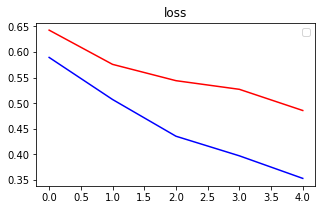

In [21]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(Number_Epochs), train_loss_values, 'r')
plt.plot(np.arange(Number_Epochs), val_loss_values, 'b')
plt.title('loss')
plt.legend()

In [23]:
### copy model to drive
import torch
model_save_name = 'Resnet18_cat_dog.pt'
path = F"/content/drive/MyDrive/Hausarbeit/{model_save_name}" 
torch.save(model.state_dict(), path)

In [24]:
model_2 = torch.load(path)

In [25]:
model_2

OrderedDict([('conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
                          6.6221